# Data Cleaning

### Objectives

* To explore the data using Profile Report
* To explore the correlation and PPS analysis
* Evaluation of missing data
* Split Train and Test Sets

### Inputs

* outputs/datasets/collection/house_price_records.csv

### Outputs

* 
* 


---

## Change working directory

We need to change the working directory from its current folder to its parent folder

* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/ames-heritage-housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/ames-heritage-housing'

---

## Load Data

In [4]:
import pandas as pd
df_house_prices = pd.read_csv(f"outputs/datasets/collection/house_prices_records.csv")
df_house_prices.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

## Data Exploration

We are interested to get more familiar with the dataset, check variable type and distribution, missing levels and what these variables mean.
* Explore the data with ProfileReport

In [5]:
%pip uninstall pandas-profiling -y
%pip install ydata-profiling

Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=df_house_prices, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Findings

* The dataset has a majority of Numeric variables (Numeric 20, Text/Categorical 4)
* Statistical guidance suggests that bias is less likely in analyses with less than 10% missingness. The percentage of missing data in this dataset is 9.8%.
* However, as 9.8% is an average of the data missing across the dataset - we will look into each variable to identify potential causation.


## Correlation and PPS

* Using correlation and predictive power score (PPS) we can carry out an initial assessment of the relationship between the different variables. 
* The functions used below are as guidance following the CI Walkthrough project 2.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

def heatmap_corr(df_house_prices, threshold, figsize=(20,12), font_annot=8):
    if len(df_house_prices.columns) > 1:
        mask = np.zeros_like(df_house_prices, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df_house_prices) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df_house_prices, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes, 
                    linewidth=0.5
                    )
        axes.set_yticklabels(df_house_prices.columns, rotation=0)
        plt.ylim(len(df_house_prices.columns), 0)
        plt.show()


def heatmap_pps(df_house_prices, threshold, figsize=(20, 12), font_annot=8):
    if len(df_house_prices.columns) > 1:
        mask = np.zeros_like(df_house_prices, dtype=np.bool)
        mask[abs(df_house_prices) < threshold] = True

        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df_house_prices, annot=True, xticklabels=True, yticklabels=True, mask=mask,
                        cmap='rocket_r',
                        annot_kws={"size": font_annot}, linewidth=0.05, linecolor='grey')
        plt.ylim(len(df_house_prices.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df_house_prices)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS theshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix

def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):
    
    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df_house_prices=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df_house_prices=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
         f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df_house_prices=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Then we use CalculateCorrAndPPS to calculate Correlations and Power Predictive Score

In [18]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df_house_prices)

/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pyenv_mirror/user/3.8.18/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("

PPS theshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



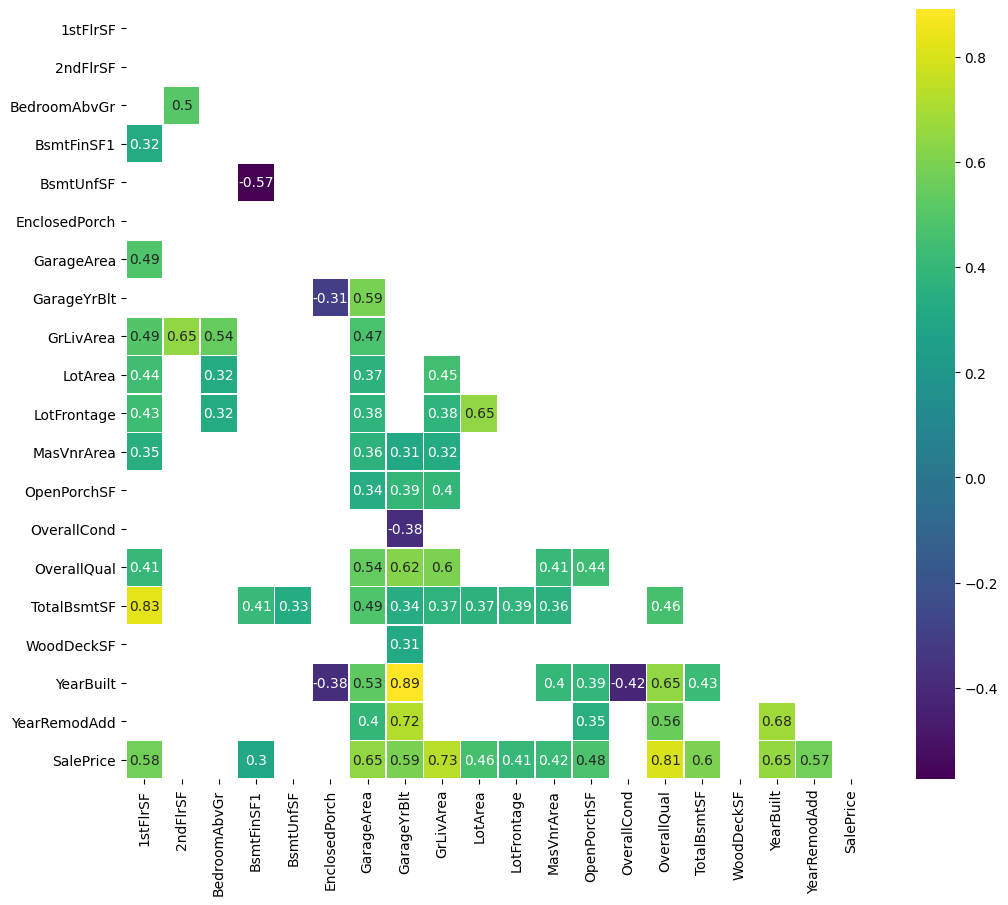



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



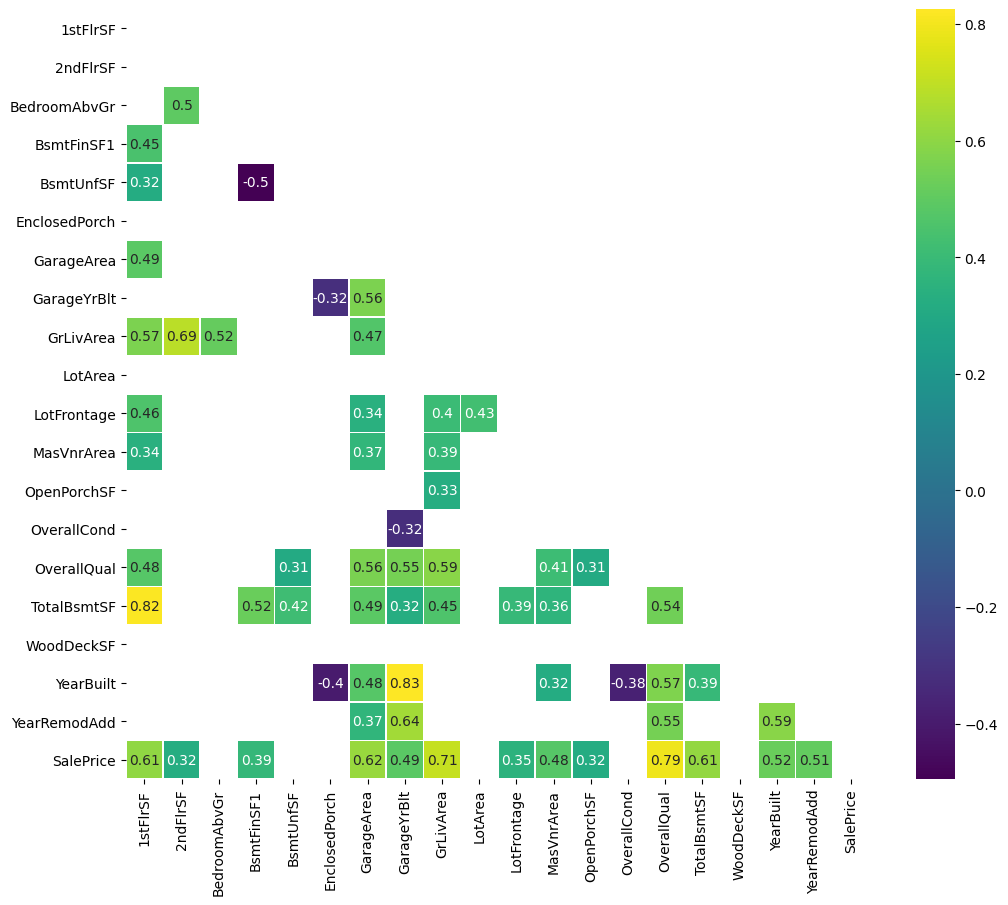



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



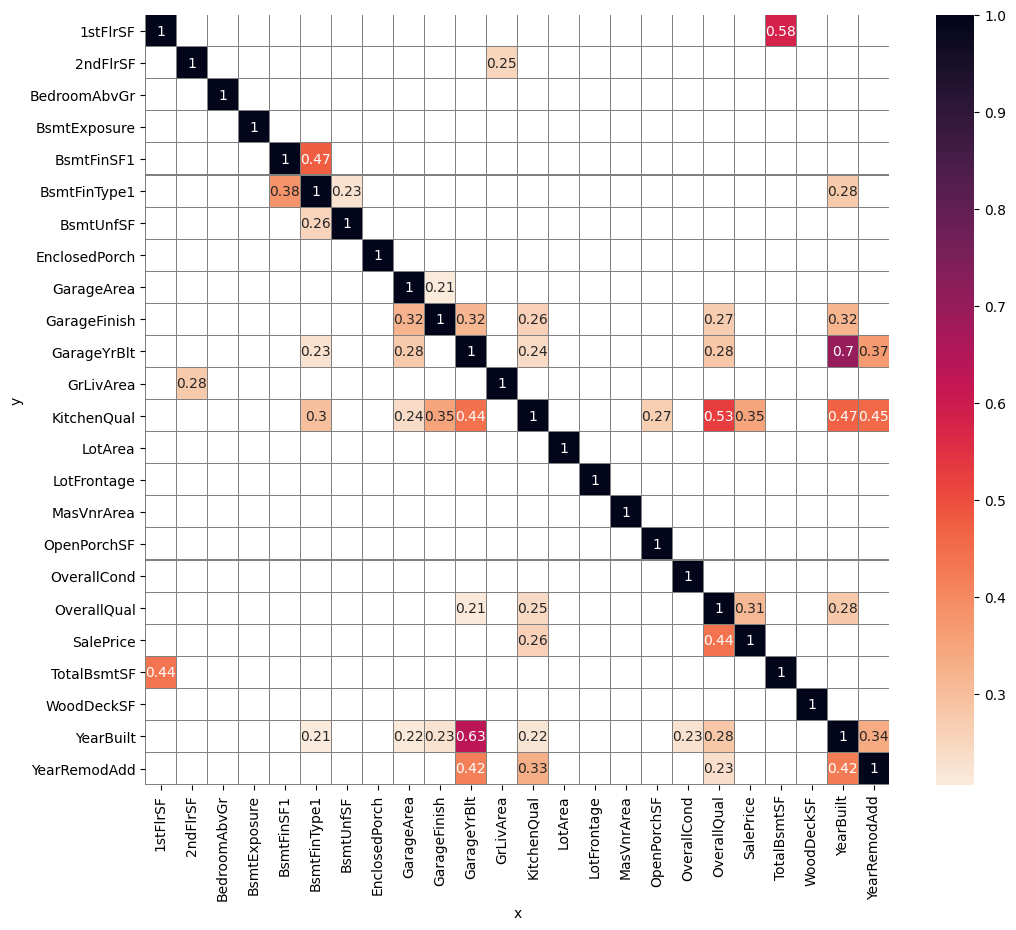

In [19]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                    df_corr_spearman = df_corr_spearman,
                    pps_matrix = pps_matrix,
                    CorrThreshold = 0.3, PPS_Threshold = 0.2,
                    figsize=(12,10), font_annot = 10)

## Findings of Missing Data

Using the custom function from the CI walkthrough Project 2, we are able to evaluate the number of missing data values and overall percentage of missing data for each variable.

In [25]:
def EvaluateMissingData(df_house_prices):
    missing_data_absolute = df_house_prices.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df_house_prices)*100, 2)
    df_missing_data = (pd.DataFrame(
        data={"RowsWithMissingData": missing_data_absolute, 
             "PercentageOfDataset": missing_data_percentage,
             "DataType": df_house_prices.dtypes}
    )
        .query("PercentageOfDataset > 0")
    )
    return df_missing_data

In [26]:
EvaluateMissingData(df_house_prices)

,RowsWithMissingData,PercentageOfDataset,DataType
2ndFlrSF,86,5.89,float64
BedroomAbvGr,99,6.78,float64
BsmtFinType1,114,7.81,object
EnclosedPorch,1324,90.68,float64
GarageFinish,162,11.10,object
GarageYrBlt,81,5.55,float64
LotFrontage,259,17.74,float64
MasVnrArea,8,0.55,float64
WoodDeckSF,1305,89.38,float64


### Review and suggestions for cleaning and imputing missing data

#### Second-floor square feet
* The variable Second-floor square feet has 5.89% of data missing.
* Looking at the Pandas Profile - 53.5% of the data is showing "Zeros", indicating that there is no second floor in these properties. 
* We could assume that the 5.89% of data missing is due to no second floor is present.
* The data is numerical and skewed, therefore imputing the data using the median is appropriate which is also 0.

#### Bedrooms above grade (does not include basement bedrooms)
* The variable Bedrooms above grade has 6.78% of data missing.
* There are 99 missing data cells which is a significant number to impute.
* Looking at the Pandas Profile we can see that the mean is 2.87 bedrooms and the median is 3.
* The standard deviation is 0.82 which shows that there is no devation from the average. Therefore we will use the median to impute.

#### Rating of basement finished area (BsmtFinType1)
* The variable Rating of basement finished area has 7.8% of data missing.
* There are 114 missing data cells.
* The datatype for this variable is based on if the basement is finished (and to what standard), unfinished and if there is no basement.
* We can imput the missing data with unfinished assuming that there is a basement (backed by the most common value type being unfinished).

#### Enclosed porch area in square feet
* The variable Enclosed porch area in square feet has 90.7% of data missing.
* There are 1324 missing data cells.
* Looking at the results from the Correlation and PPS reports - there is no direct correlation to the SalesPrice.
* We can drop this variable.

#### Garage Finish - Interior finish of the garage
* The variable Garage Finish has 11.1% of data missing.
* There are 162 data cells missing.
* Looking at the Pandas Profile, we can see that 42.1% of the Garage Finishes are 'Unfinished'.
* We can imput the missing data with unfinished assumed by most common value.

#### Garage Year Built - Year garage was built
* The variable Garage Year Built has 5.5% of data missing.
* There are 81 data cells missing.
* There is a strong correlation between the Garage Year Built and the SalesPrice.
* As the data distribution is not symmetric - we can use the median over the mean to impute the missing data.
* We can impute the missing data with the median Garage Year Built, 1980. 

#### Lot Frontage - Linear feet of street connected to property
* The variable Lot Frontage has 17.7% of data missing.
* There is 259 data cells missing.
* Looking at the results from the Correlation and PPS reports - there is a moderate correlation between the Lot Frontage and the SalesPrice.
* The data distribution is not symmetric - we can use the median over the mean to impute the missing data.
* We can impute the missing data with the median Lot Frontage of 69 (feet).

#### MasVnrArea - Masonry veneer area in square feet
* The variable Masonry veneer area has 0.5% of data missing.
* There are 8 data cells missing.
* Looking at the results from the Correlation and PPS reports - there is a strong correlation with the SalesPrice.
* Looking at the Pandas Profile - 59% of the Masonry veneer area data is 0 (as is the median).
* We can imput the missing data with the median Masonry veneer area of 0 (square feet)

#### WoodDeckSF - Wood deck area in square feet
* The variable Wood deck in square feet has 89.4% of data missing.
* There is 1305 data cells missing.
* Looking at the results from the Correlation and PPS reports - there is no correlation with the SalesPrice.
* We can drop this variable.


### Based on our review above we will conduct the following:
- Data to clean/ impute:
    * 2ndFlrSF - Second Floor square feet - we will impute the missing data with 0.
    * BedroomAbvGr - Bedrooms above grade - we will impute the missing data with 3.
    * BsmtFinType1 - Rating of basement finished area - we will impute the missing data with Unf.
    * GarageFinish - Interior finish of garage - we will impute the missing data with Unf.
    * GarageYrBlt - Year garage was built - we will impute the missing data with 1980.
    * LotFrontage - Linear feet of street connected to property - we will impute the missing data with 69.
    * MasVnrArea - Masonry veneer area - we will impute the missing data with 0.
- Data to drop:
    * EnclosedPorch - Enclosed porch area.
    * WoodDeckSF - Wood deck area.
    

### Assessing Data Cleaning

We will carry out the following steps in order to complete the data cleaning process:
1. Drop the data that we will not use.
2. Select imputations to apply to the variables that we want to impute.
3. Create a dataframe to apply the method
4. Assess the effect of imputation.

To assess the effects of cleaning, we want to use the DataCleaningEffect function from the Code Institute Feature Engine Module.

In [38]:
def DataCleaningEffect(df_house_prices_original, df_house_prices_cleaned, variables_applied_with_method):
    # Indicate plot number
    flag_count=1

    # Distinguish between numerical and categorical valuables
    categorical_variables = df_house_prices_original.select_dtypes(exclude=['number']).columns

    # Scan over variables,
    # first on variables that apply the metho
    # if the variable is a numerical plot, a histogram if categorical a barplot
    for set_of_variables in [variables_applied_with_method]:
        print("\n==============================================================================")
        print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
        print(f"{set_of_variables} \n\n")

        for var in set_of_variables:
            if var in categorical_variables: # it is categorical variable: barplot

                df1 = pd.DataFrame({"Type":"Original","Value":df_house_prices_original[var]})
                df2 = pd.DataFrame({"Type":"Cleaned","Value":df_house_prices_cleaned[var]})
                dfAux = pd.concat([df1, df2], axis=0)
                fig , axes = plt.subplots(figsize=(15, 5))
                sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
                axes.set(title=f"Distribution Plot {flag_count}: {var}")
                plt.xticks(rotation=90)
                plt.legend()
            
            else: # it is a numerical variable: histogram

                fig , axes = plt.subplots(figsize=(10,5))
                sns.histplot(data=df_house_prices_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
                sns.histplot(data=df_house_prices_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
                axes.set(title=f"Distribution Plot {flag_count}: {var}")
                plt.legend()
            
            plt.show()
            flag_count+= 1

1. ArbitraryDrop the variables 'EnclosedPorch' and 'WoodDeckSF' using the Drop Variables imputation approach.

In [39]:
from feature_engine.selection import DropFeatures

features_to_drop = DropFeatures(features_to_drop = ['EnclosedPorch', 'WoodDeckSF' ])

df_house_prices_transformed = features_to_drop.fit_transform(df_house_prices)
df_house_prices_transformed.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1460 non-null   int64  
 1   2ndFlrSF      1374 non-null   float64
 2   BedroomAbvGr  1361 non-null   float64
 3   BsmtExposure  1460 non-null   object 
 4   BsmtFinSF1    1460 non-null   int64  
 5   BsmtFinType1  1346 non-null   object 
 6   BsmtUnfSF     1460 non-null   int64  
 7   GarageArea    1460 non-null   int64  
 8   GarageFinish  1298 non-null   object 
 9   GarageYrBlt   1379 non-null   float64
 10  GrLivArea     1460 non-null   int64  
 11  KitchenQual   1460 non-null   object 
 12  LotArea       1460 non-null   int64  
 13  LotFrontage   1201 non-null   float64
 14  MasVnrArea    1452 non-null   float64
 15  OpenPorchSF   1460 non-null   int64  
 16  OverallCond   1460 non-null   int64  
 17  OverallQual   1460 non-null   int64  
 18  TotalBsmtSF   1460 non-null 

2. Categorical Imputer: Impute the variables 'BsmtFinType1', 'GarageFinish' with the value of 'Unf'


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['BsmtFinType1', 'GarageFinish'] 




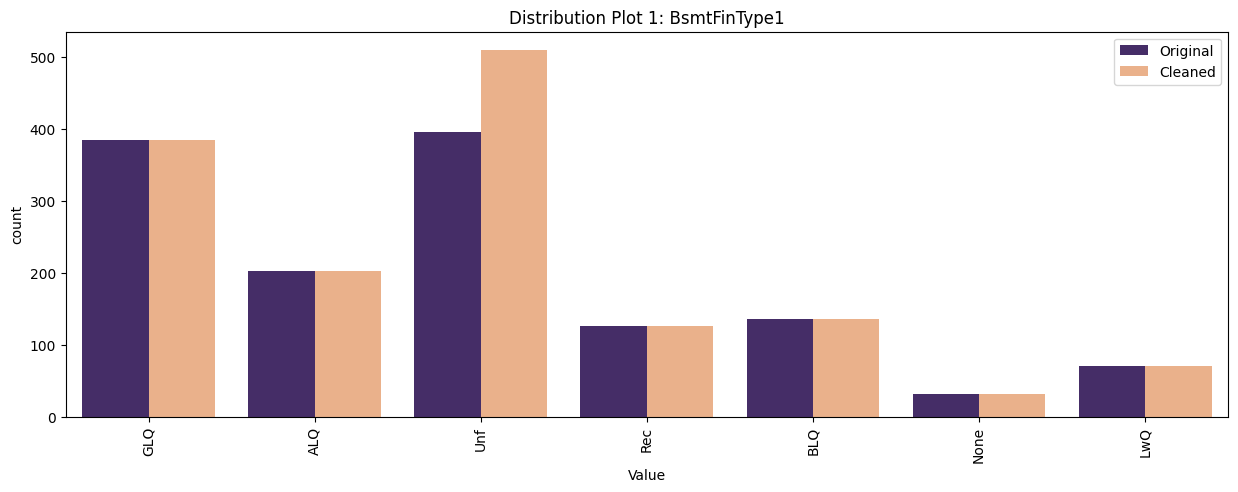

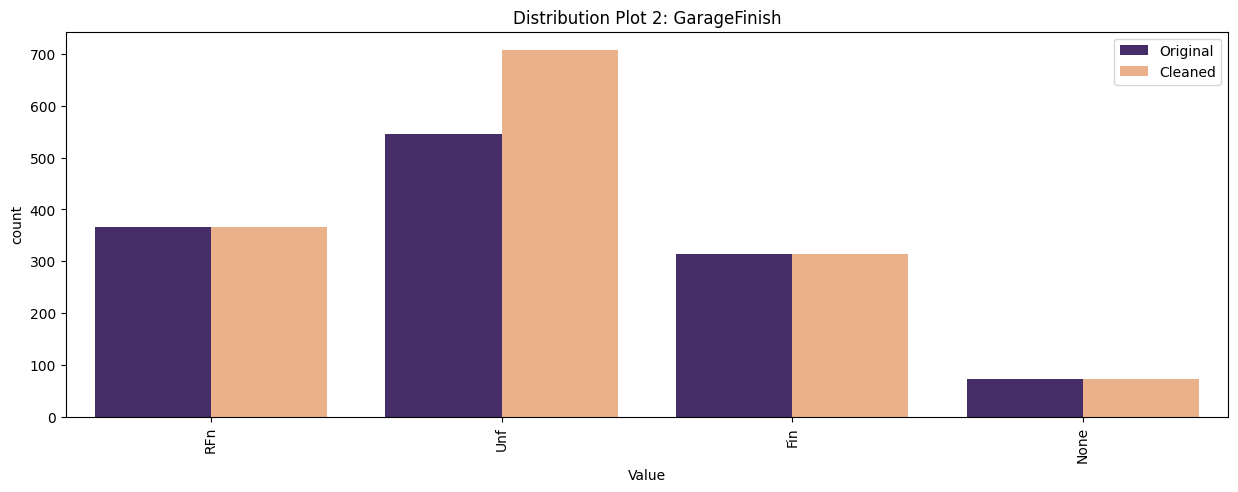

In [40]:
from feature_engine.imputation import CategoricalImputer

features_to_impute = ['BsmtFinType1', 'GarageFinish']
features_to_impute

imputer = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=features_to_impute)

df_house_prices_method = imputer.fit_transform(df_house_prices_transformed)

DataCleaningEffect(df_house_prices_original=df_house_prices, 
                    df_house_prices_cleaned=df_house_prices_method,
                    variables_applied_with_method=features_to_impute)


3. Arbitrary Number Imputation


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF', 'MasVnrArea'] 




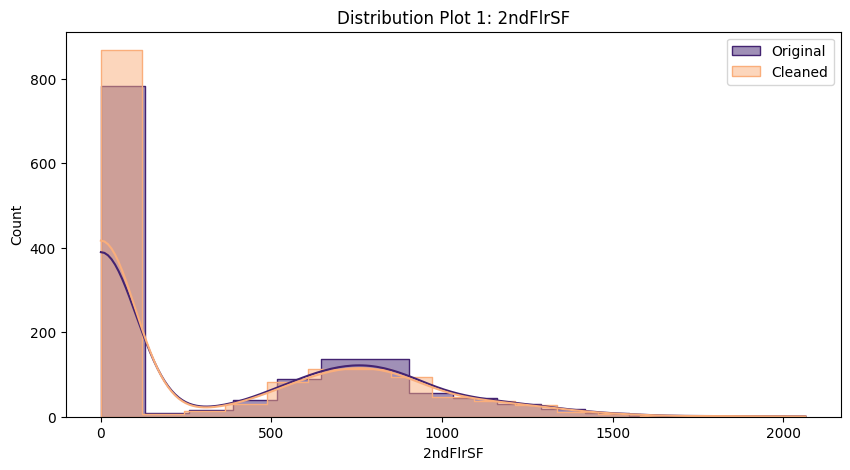

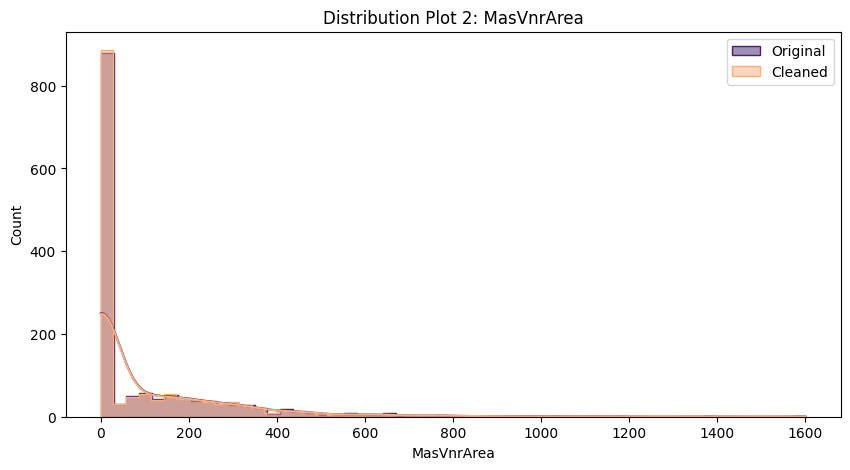

In [41]:
from feature_engine.imputation import ArbitraryNumberImputer

features_to_impute = ['2ndFlrSF', 'MasVnrArea']
features_to_impute

imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=features_to_impute)
df_house_prices_method = imputer.fit_transform(df_house_prices_transformed)

DataCleaningEffect(df_house_prices_original=df_house_prices, 
                    df_house_prices_cleaned=df_house_prices_method,
                    variables_applied_with_method=features_to_impute)

4. MeanMedianImputer: Impute the variables 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage' with the median values.


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'] 




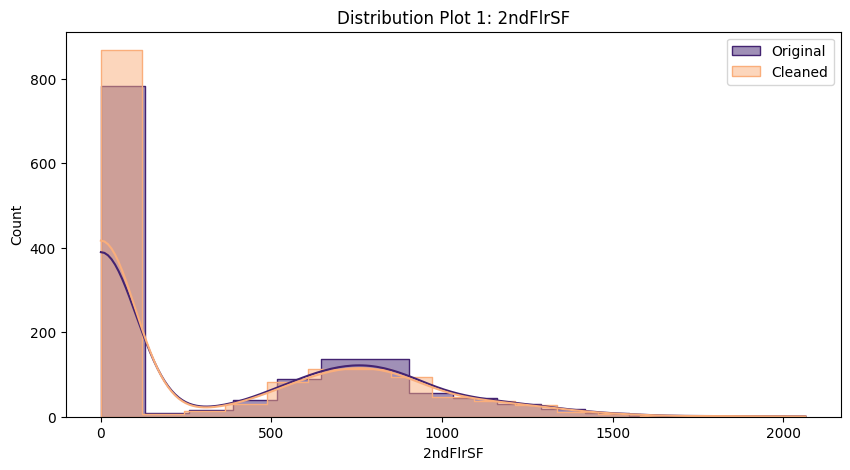

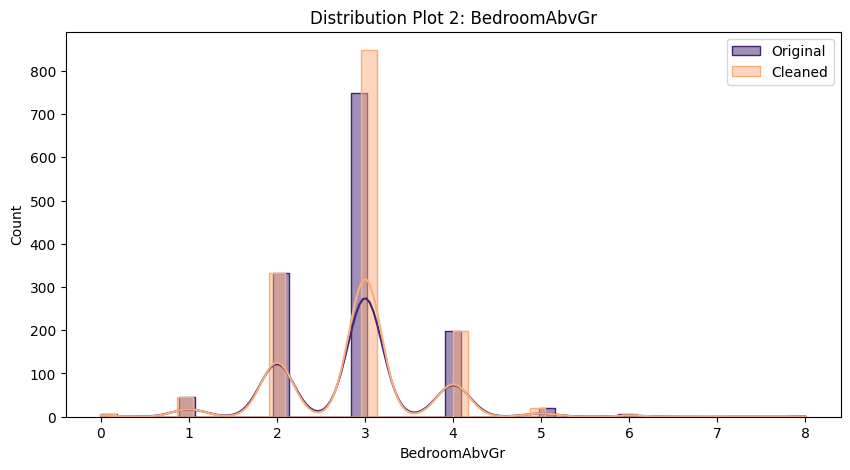

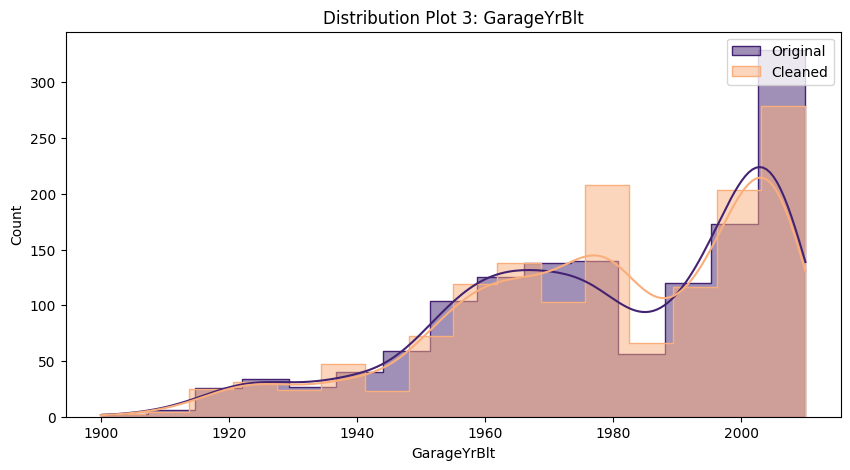

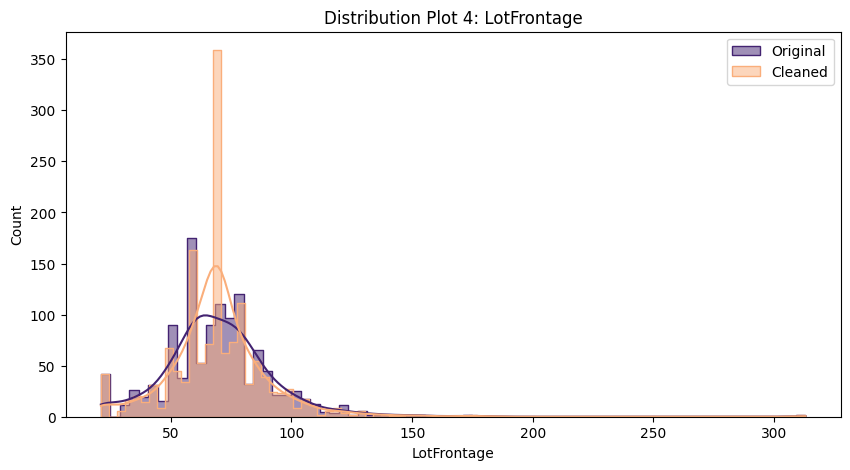

In [43]:
from feature_engine.imputation import MeanMedianImputer

features_to_impute = ['2ndFlrSF', 'BedroomAbvGr', 'GarageYrBlt', 'LotFrontage']
features_to_impute

imputer = MeanMedianImputer(imputation_method='median', variables=features_to_impute)
df_house_prices_method = imputer.fit_transform(df_house_prices_transformed)

DataCleaningEffect(df_house_prices_original=df_house_prices, 
                    df_house_prices_cleaned=df_house_prices_method,
                    variables_applied_with_method=features_to_impute)

## Conclusions